# MASCDB precooked retrievals
We want to illustrate here how the available, pre-cooked, algorithms and microphysical retrievals can be used to
filter and manipulate the data.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16,
    "legend.frameon": False,
    "font.family": "sans-serif",
    "mathtext.default": "regular"})
mpl.rcParams['figure.dpi'] = 400

# MASC DB
from mascdb.api import MASC_DB

dir_path = "/data/MASC_DB" #It must contains the 4 parquet files and the Zarr storage

# Create MASC_DB instance
mascdb = MASC_DB(dir_path=dir_path)

## Blowing snow identification / removal

In strong wind conditions, blowing snow may be recorded by MASC. The method of *Schaer et al, 2020*, available in the database, analyizes the raw MASC images and estimates if the measurments are associated to pure precipitation, blowing snow or a mixed environment.  

In this example, we show some differences of blowing snow and precipitation populations and illustrate some built-in functions to filter the data according to blowing snow.

In [2]:
# Select two campaigns, to simplify the dataset
mascdb_in = mascdb.select_campaign(['APRES3-2016','Valais-2016'])

(0.0, 0.01)

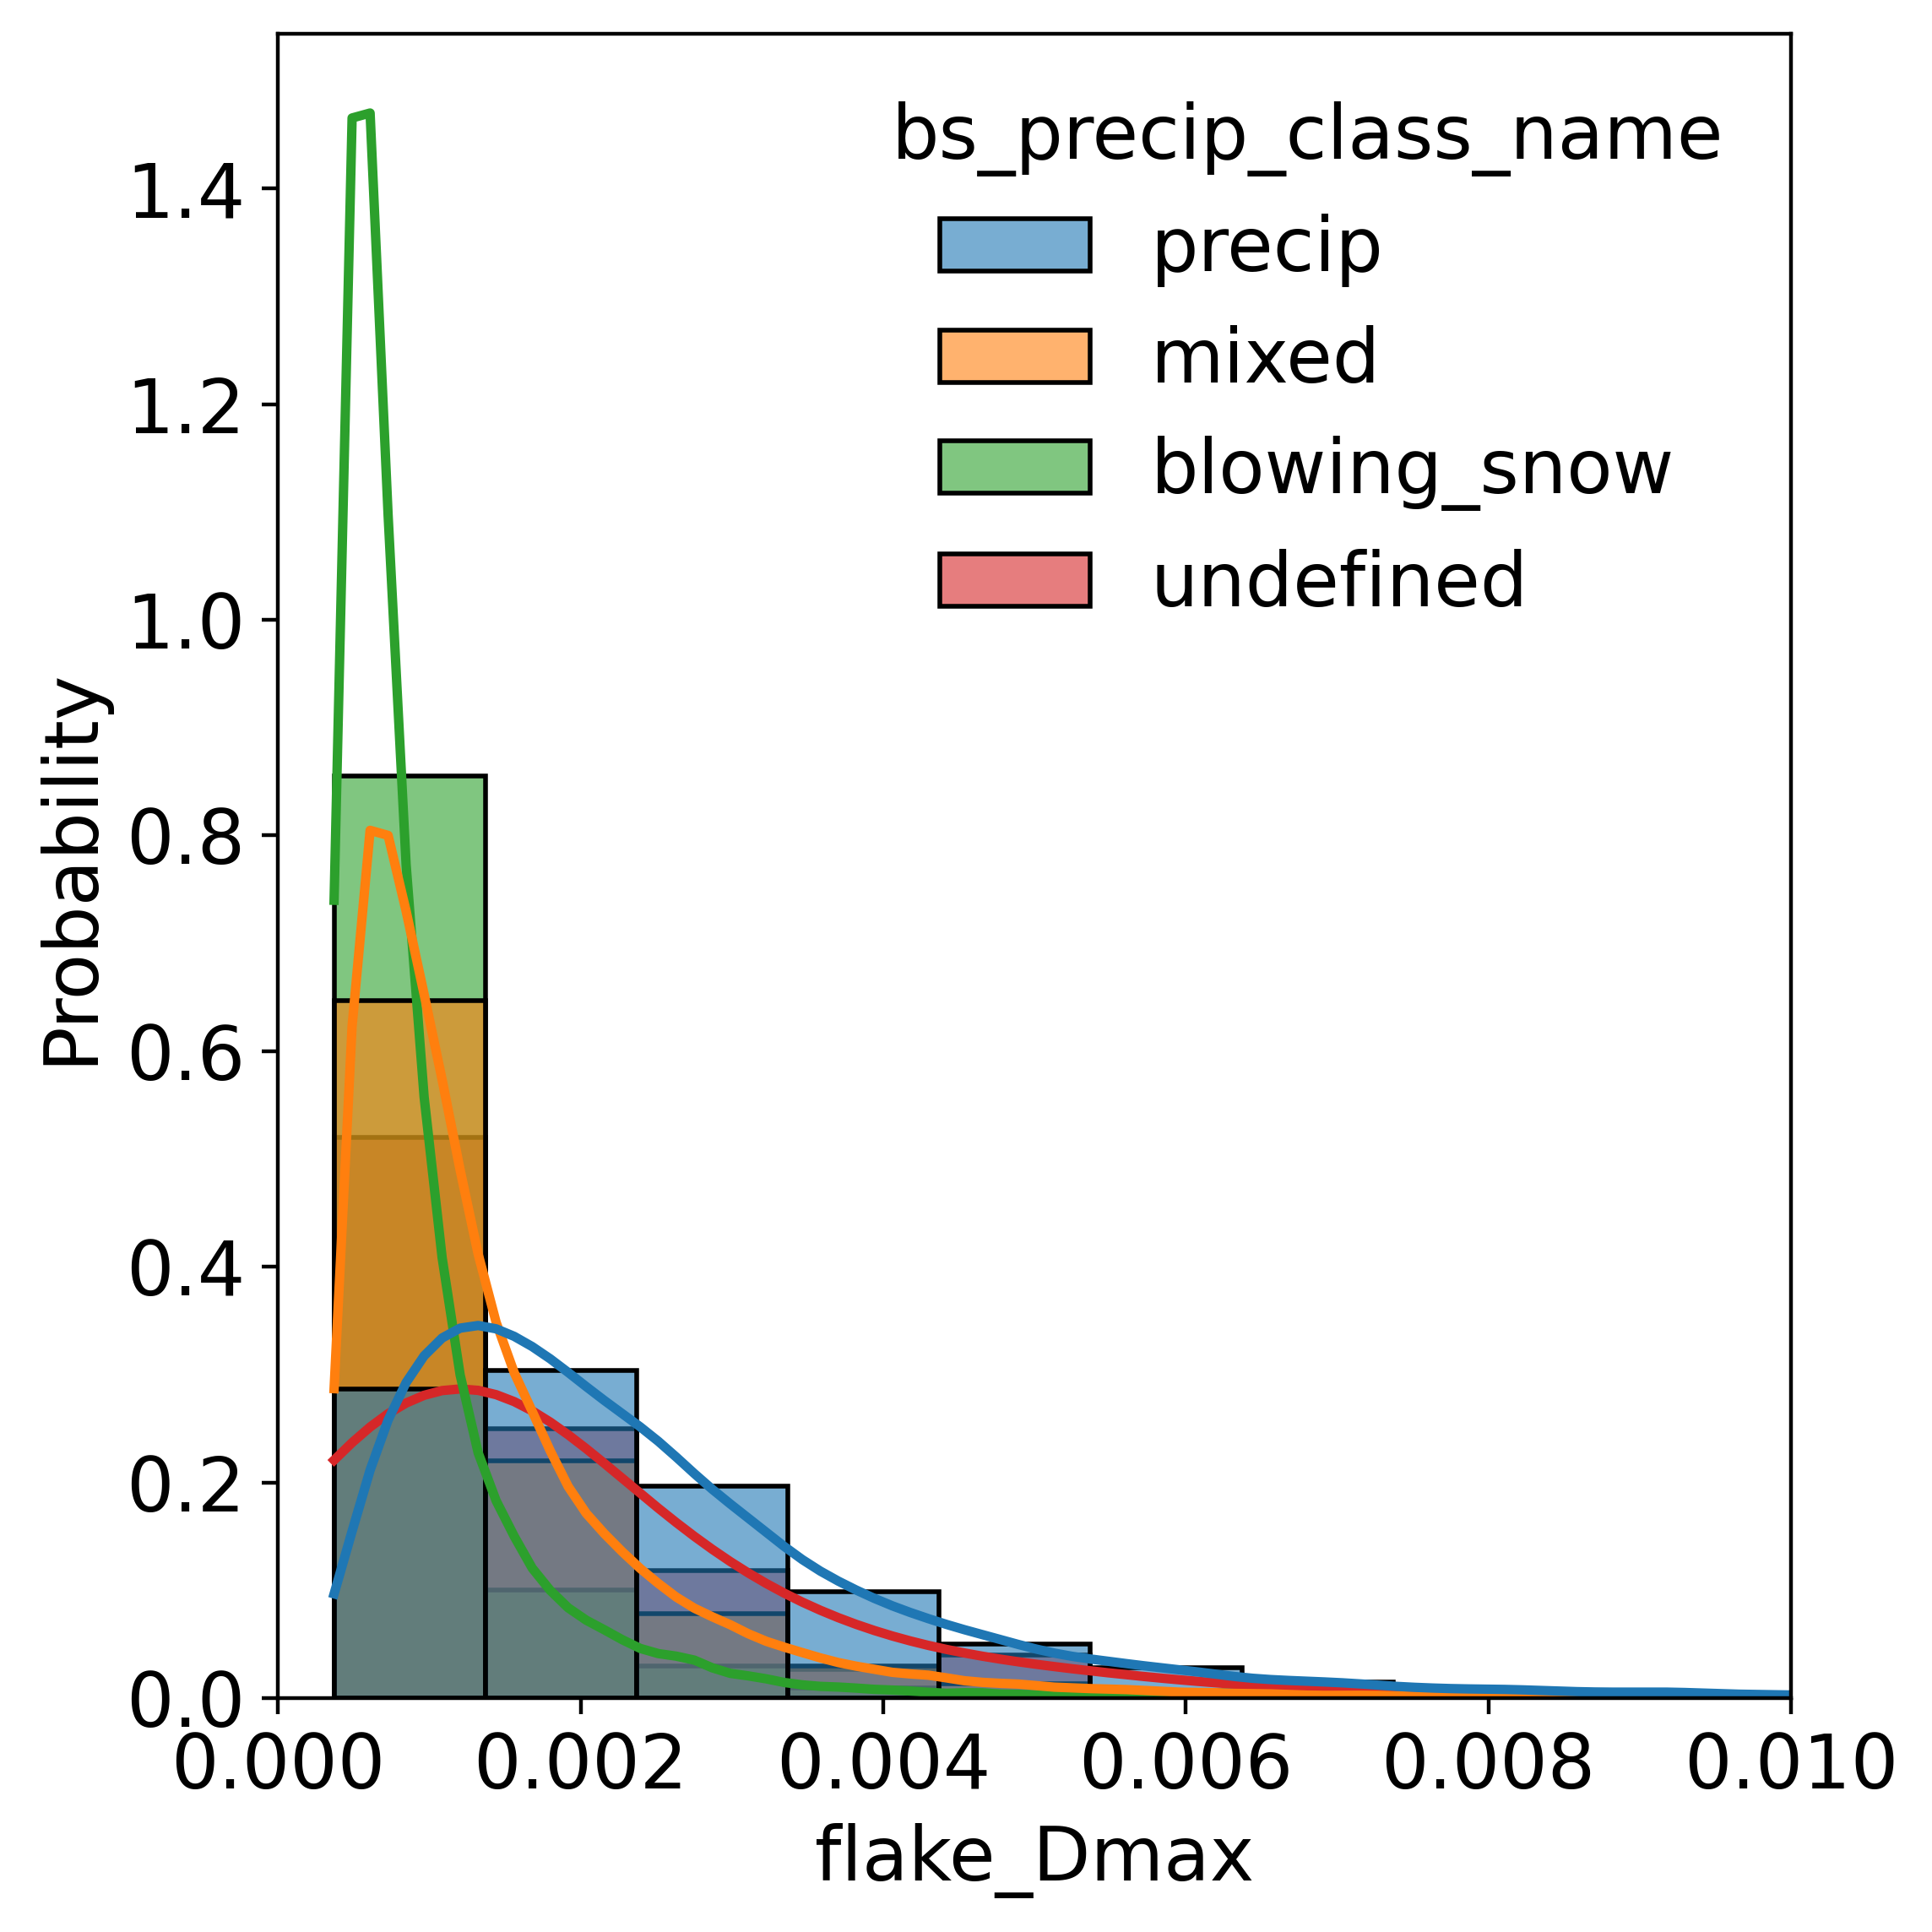

In [3]:
# Plot Dmax as a function of the blowing snow class
plt.figure(figsize=(6,6), tight_layout=True)
ax=mascdb_in.triplet.sns.histplot(x='flake_Dmax',
                              color='gray',
                              hue='bs_precip_class_name',
                              alpha=0.6,
                              kde=True,
                              stat='probability',
                              common_norm=False,
                              binwidth=0.001,
                              line_kws={"lw":2})
ax.set_xlim(0,0.01)

As expected, the population of blowing snow particles is composed of much smaller particles. We may want to filter them and compute other statistics

In [4]:
# Filter out all the blowing snow observations
print("Average Dmax [mm] (all data): ", np.round(mascdb_in.triplet.flake_Dmax.mean()*1e3,2))
mascdb_filt = mascdb_in.discard_precip_class('blowing_snow')
print("Average Dmax [mm] (no blowing snow): ",   np.round(mascdb_filt.triplet.flake_Dmax.mean()*1e3,2))

# Or alternatively keep only pure precipitation
mascdb_filt = mascdb_in.select_precip_class('precip')
print("Average Dmax [mm] (only precip): ",np.round(mascdb_filt.triplet.flake_Dmax.mean()*1e3,2))

Average Dmax [mm] (all data):  1.58
Average Dmax [mm] (no blowing snow):  1.68
Average Dmax [mm] (only precip):  2.46


## Hydrometeor classification

Hydrometeor classification (from *Praz et al 2017*), provides a useful way to stratify the data. 

Let us now play a little bit with the hydrometeor classification options. For example we can see how some descriptors vary with different hydrometeor types. 

In [5]:
# Keep for simplicity only some campaigns
mascdb_in = mascdb.select_campaign(['APRES3-2016','Valais-2016'])
mascdb_in.campaign # show the campaign summary (nice tool)

,start_time,end_time,latitude,longitude,altitude,n_triplets,n_events,event_duration_min,event_duration_mean,event_duration_max,total_event_duration,snowflake_class,riming_class,melting_class,precipitation_class
campaign,,,,,,,,,,,,,,,
APRES3-2016,2015-11-11 08:34:45.505549,2016-01-29 08:09:15.299949,-66.6628,140.0014,41.0,58836,71,0 days,0 days 03:18:16.037248661,1 days 21:59:18.178246,9 days 18:36:58.644655,"{'small_particle': 29146, 'graupel': 19765, 'a...","{'graupel': 37508, 'rimed': 14162, 'unrimed': ...","{'dry': 58352, 'melting': 484}","{'mixed': 29292, 'blowing_snow': 15955, 'preci..."
Valais-2016,2016-12-19 01:58:28.798848,2017-04-03 18:43:09.876719,46.1222,7.2122,2370.0,119261,95,0 days,0 days 06:19:57.036079105,2 days 14:09:30.196810,25 days 01:35:18.427515,"{'graupel': 52407, 'small_particle': 34095, 'a...","{'graupel': 82279, 'rimed': 29119, 'densely_ri...","{'dry': 118901, 'melting': 360}","{'mixed': 84649, 'precip': 26422, 'blowing_sno..."


(0.0, 0.5)

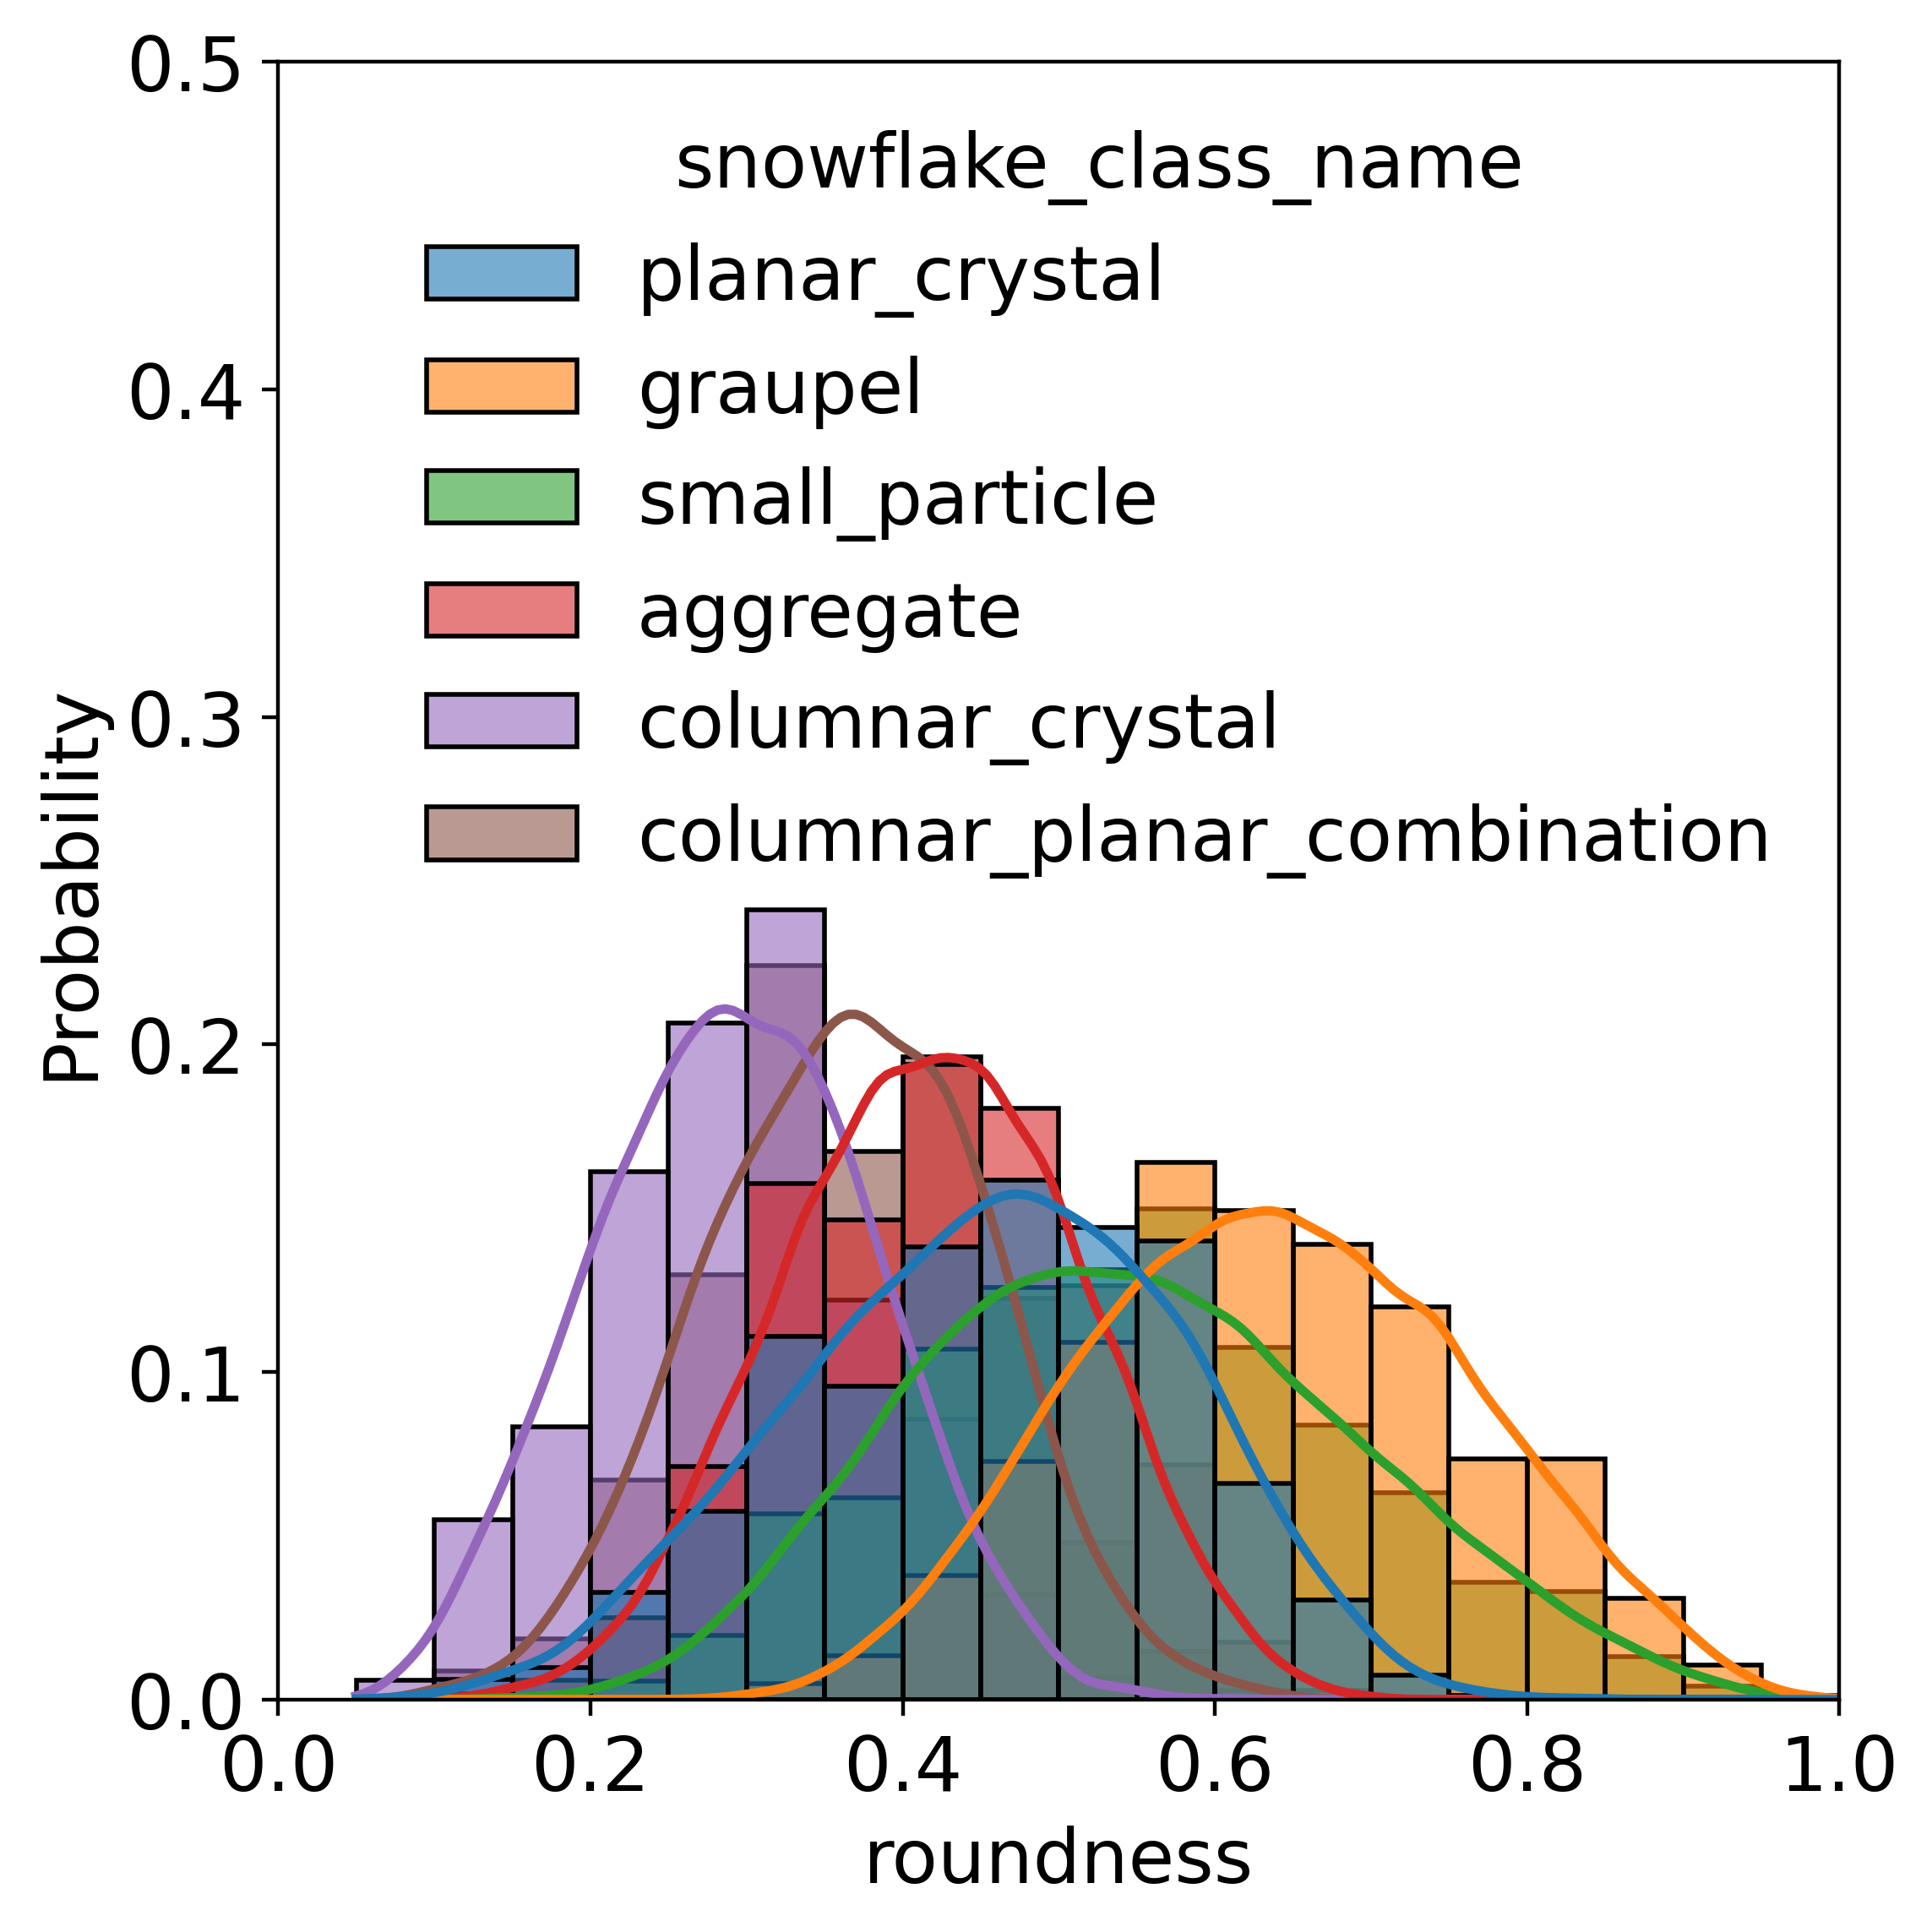

In [6]:
# Plot the distribution of "roundness" (of CAM1 in this example) as function of hydro class
# Plot Dmax as a function of the blowing snow class
plt.figure(figsize=(6,6), tight_layout=True)
ax=mascdb_in.cam1.sns.histplot(x='roundness',
                              color='gray',
                              hue='snowflake_class_name',
                              alpha=0.6,
                              kde=True,
                              stat='probability',
                              common_norm=False,
                              binwidth=0.05,
                              line_kws={"lw":2})
ax.set_xlim(0,1)
ax.set_ylim(0,0.5)

We may want now to see some images of snowflakes classified in a certain hydrometeor class, for example *planar crystals* or *aggregates*. Let us take the chance to showcase some more filtering. 

- Let's select only snowflakes with a good quality ($\xi$ of *Praz et al 2017*)
- Let's select only classification outputs of high probability (over the 3 cameras, so to ensure also consistency)

Note that most of what done here for the triplet as a whole can be done even for individual cameras.

In [7]:
# Keep for simplicity only some campaigns
mascdb_in = mascdb.select_campaign(['Davos-2015','ICEPOP-2018'])

In [8]:
# Filter on quality
print("Number of flakes:", len(mascdb_in))
print("Filtering on average triplet image quality > 9.5")
idx = mascdb_in.triplet['flake_quality_xhi'] > 9.5
mascdb_in = mascdb_in.isel(idx)

print("Number of flakes:", len(mascdb_in))
# Filter on classification probability
print("Filtering on average triplet hydrometeor classification probabiliy > 0.9")
idx = mascdb_in.triplet['snowflake_class_prob'] > 0.9
mascdb_in = mascdb_in.isel(idx)

print("Number of flakes:", len(mascdb_in))

Number of flakes: 232307
Filtering on average triplet image quality > 9.5
Number of flakes: 51590
Filtering on average triplet hydrometeor classification probabiliy > 0.9
Number of flakes: 17549


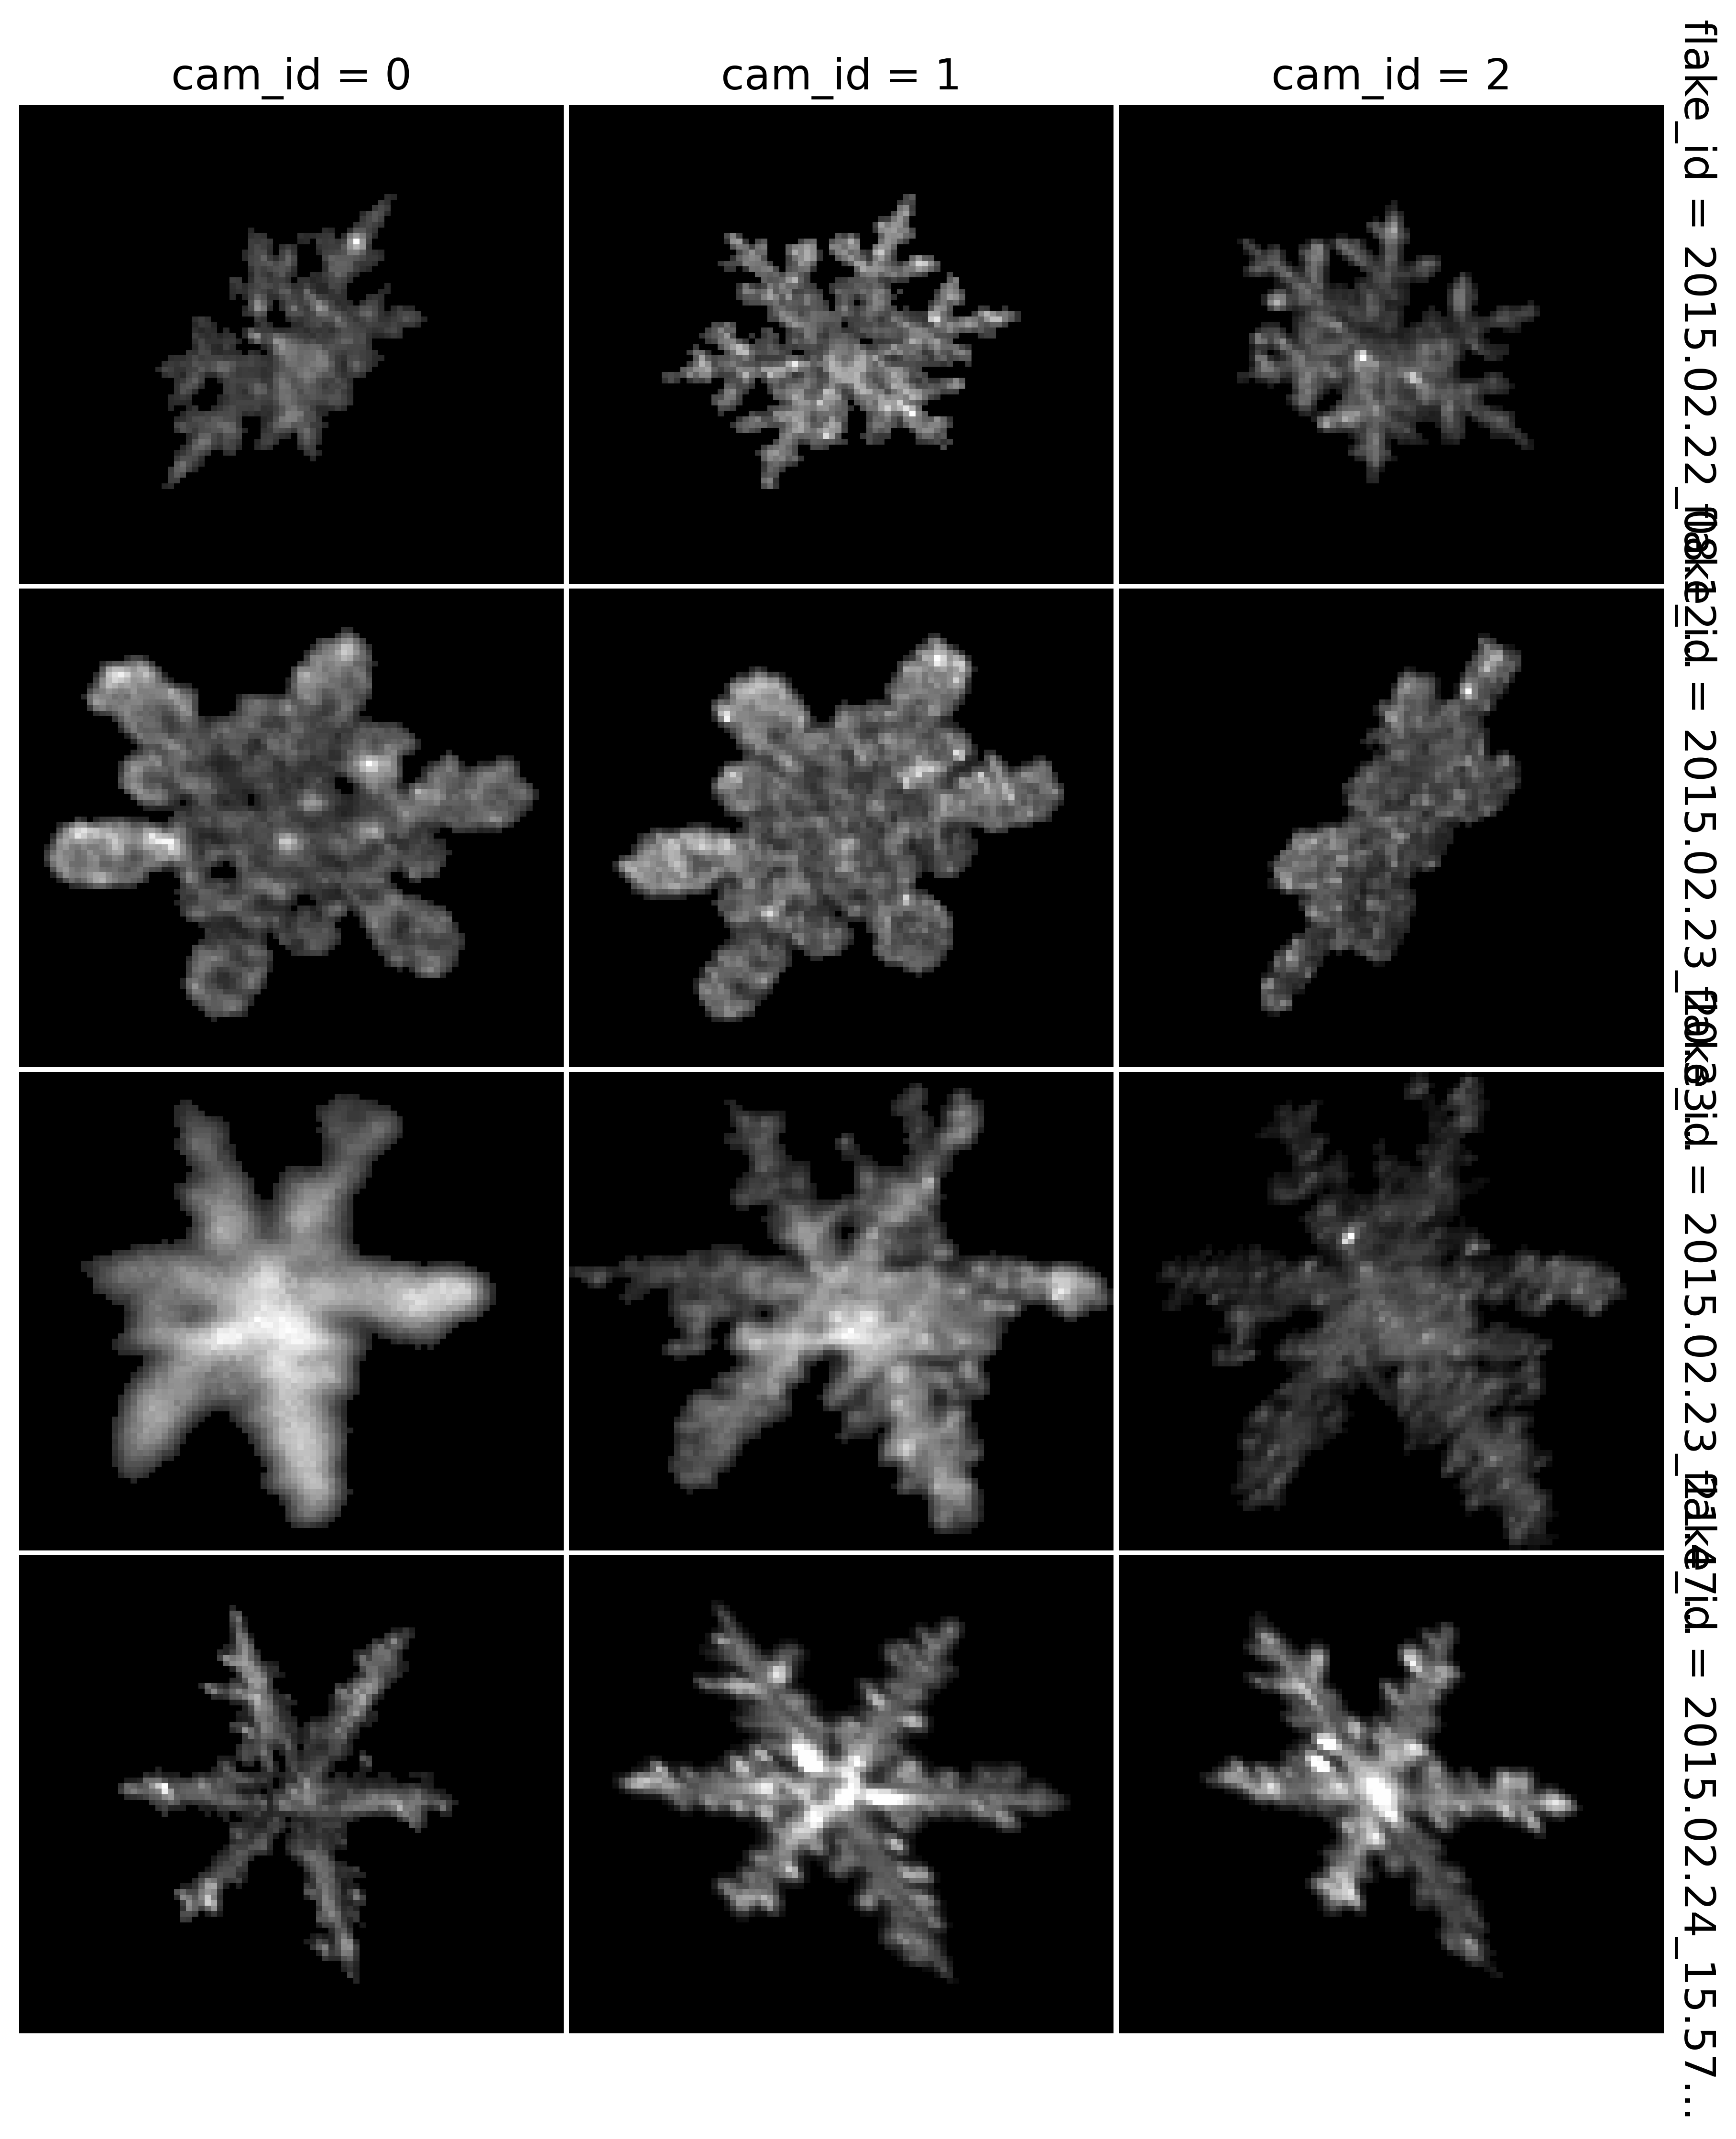

In [9]:
# Plot some planar crystals for example
mascdb_planar = mascdb_in.select_snowflake_class("planar_crystal")
mascdb_planar.plot_triplets(n_triplets = 4, zoom=True)

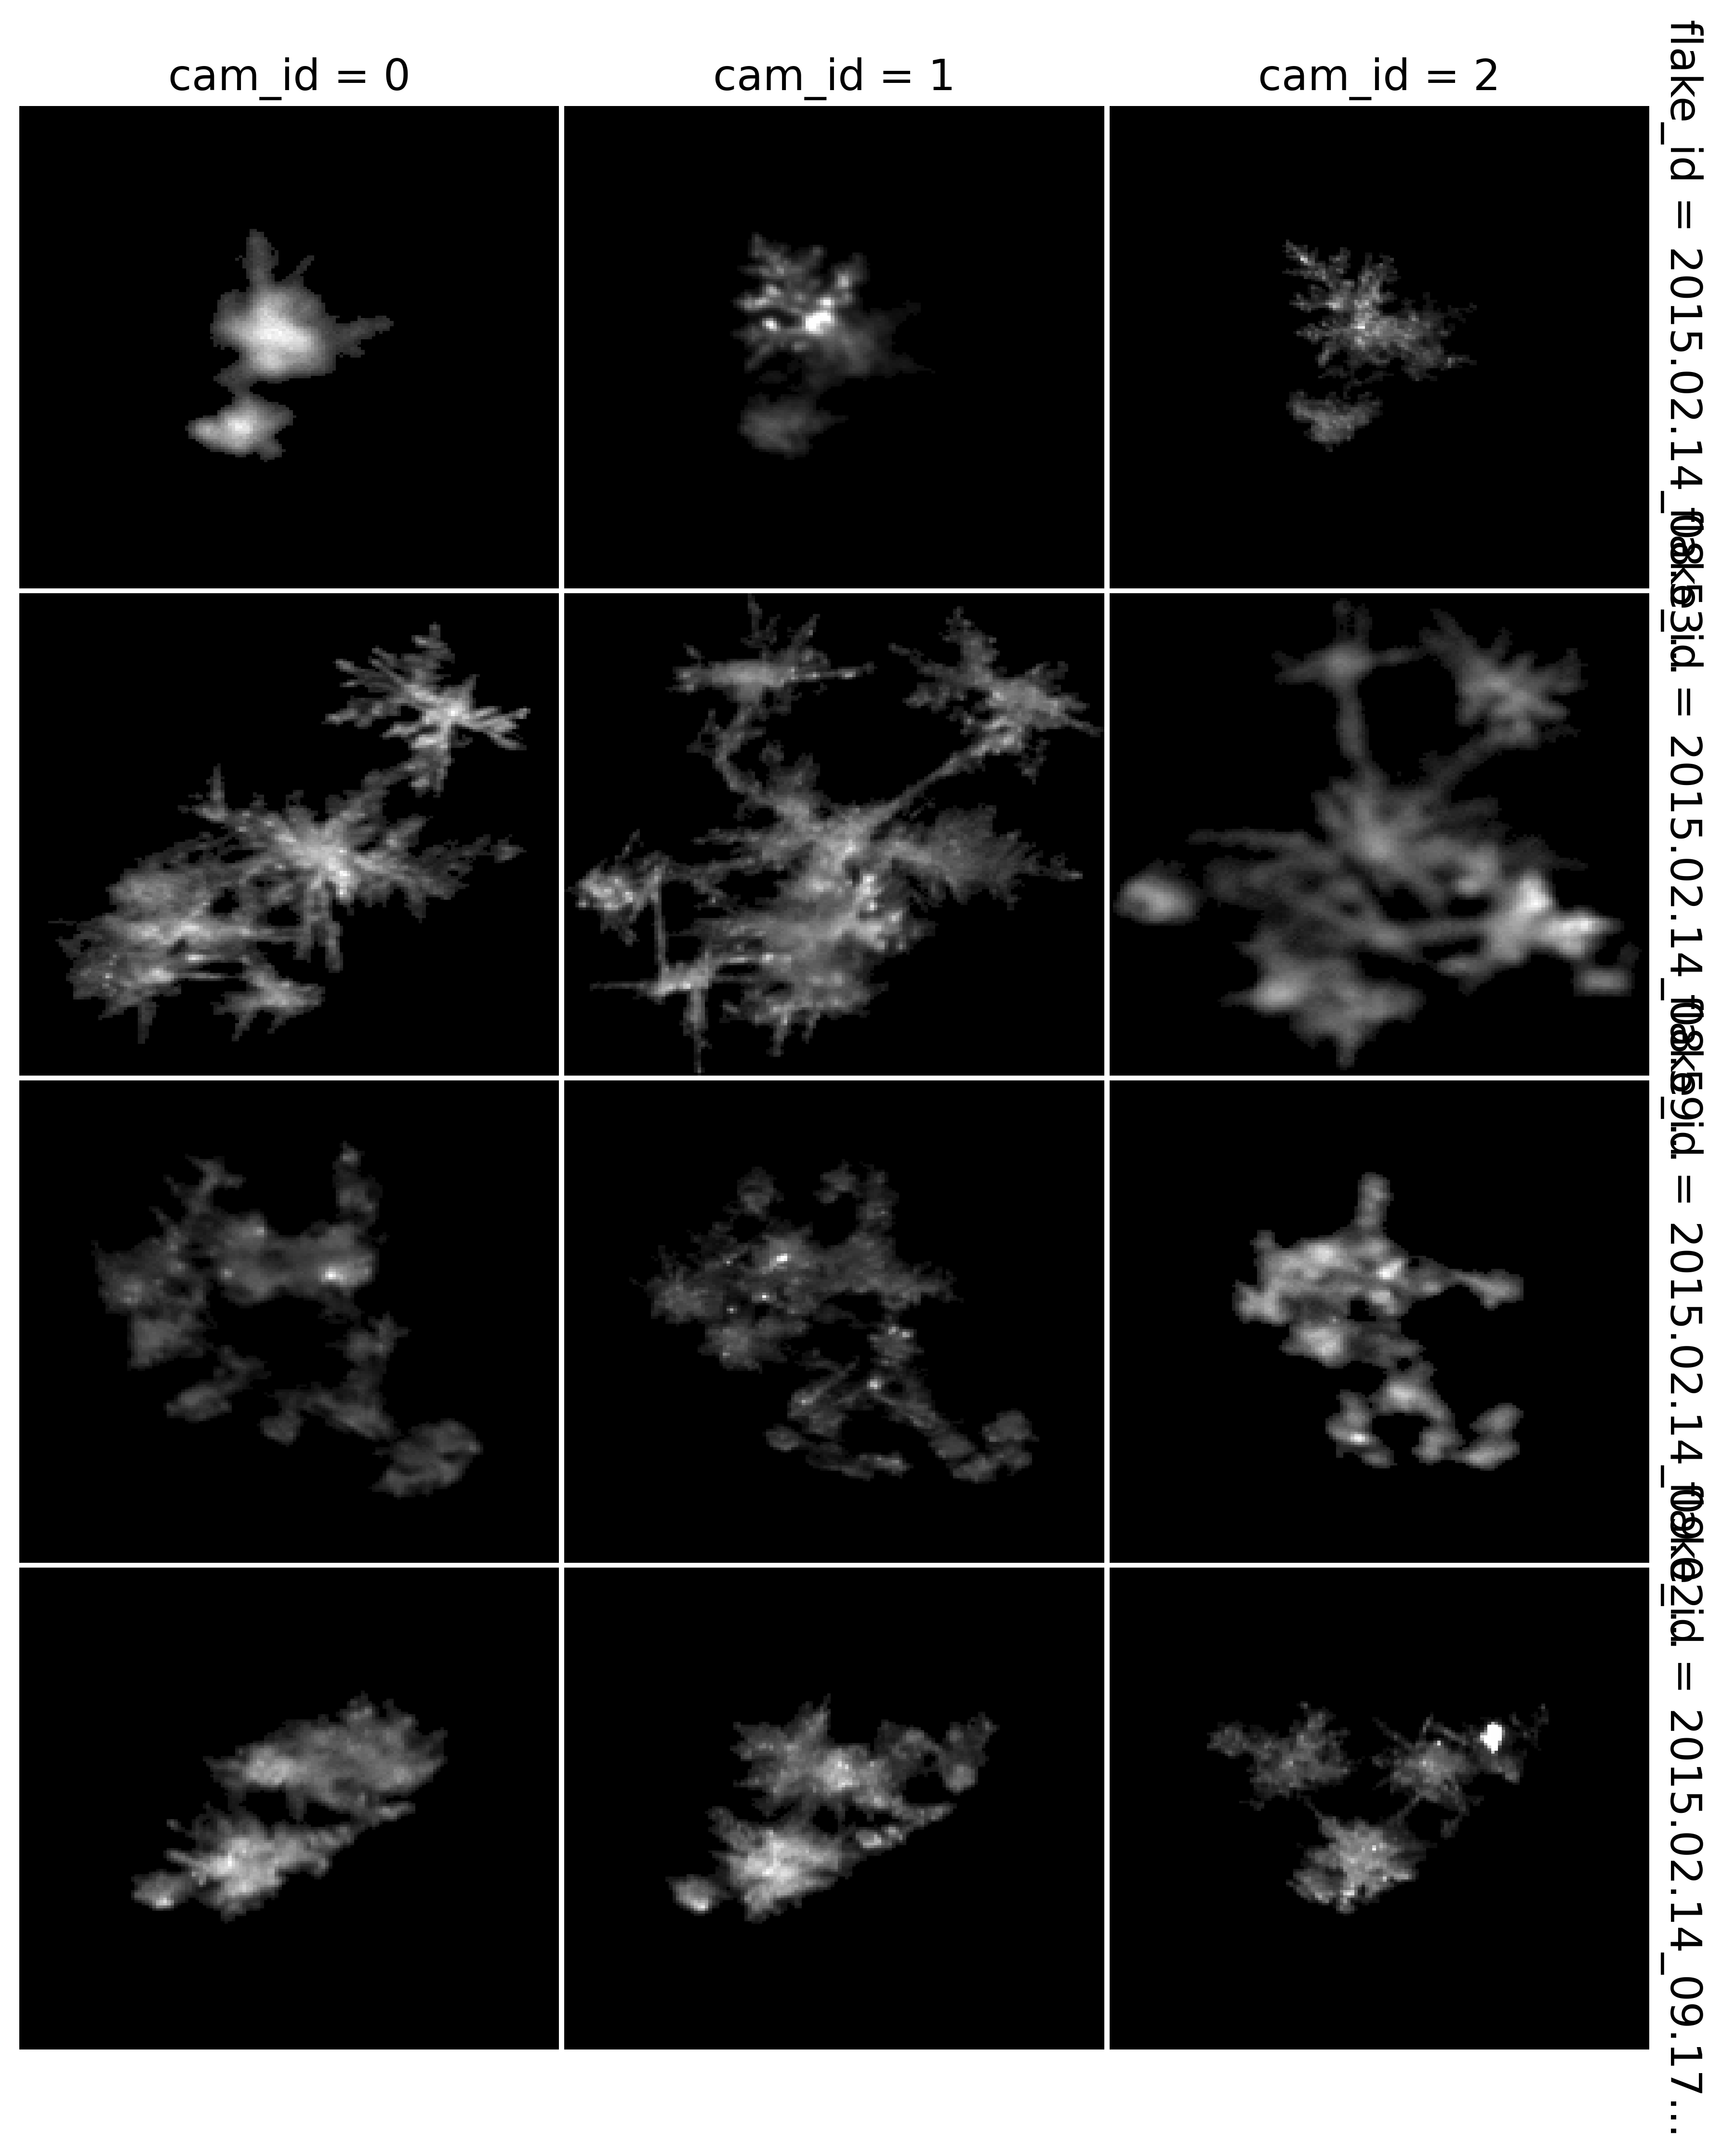

In [10]:
# Plot some aggregates for example
mascdb_agg = mascdb_in.select_snowflake_class("aggregate")
mascdb_agg.plot_triplets(n_triplets = 4, zoom=True)

## Riming degree estimation
Also riming degree follows the work of *Praz et al 2017*, and various riming degree classes can be estimated. 
We will now:

- Pre-filter the dataset
- See statistics of each riming class
- Plot some examples

In [11]:
# Let's use the entire dataset now, with some heavy filtering
mascdb_in = mascdb.select_precip_class('precip')        # 1: no blowing snow or mixed precipitation
mascdb_in = mascdb_in.discard_melting_class('melting')  # 2: remove particle showing melting morphology

# 2b: use also the available temperature info to keep only data < 0°C
idx       = mascdb_in.triplet['env_T'] < 0
mascdb_in = mascdb_in.isel(idx)

# 3: remove small particles as riming would be hard to see anyway
mascdb_in = mascdb_in.discard_snowflake_class('small_particle')

# 4: keep only good quality images (xi > 9.5)
idx = mascdb_in.triplet['flake_quality_xhi'] > 9.5
mascdb_in = mascdb_in.isel(idx)

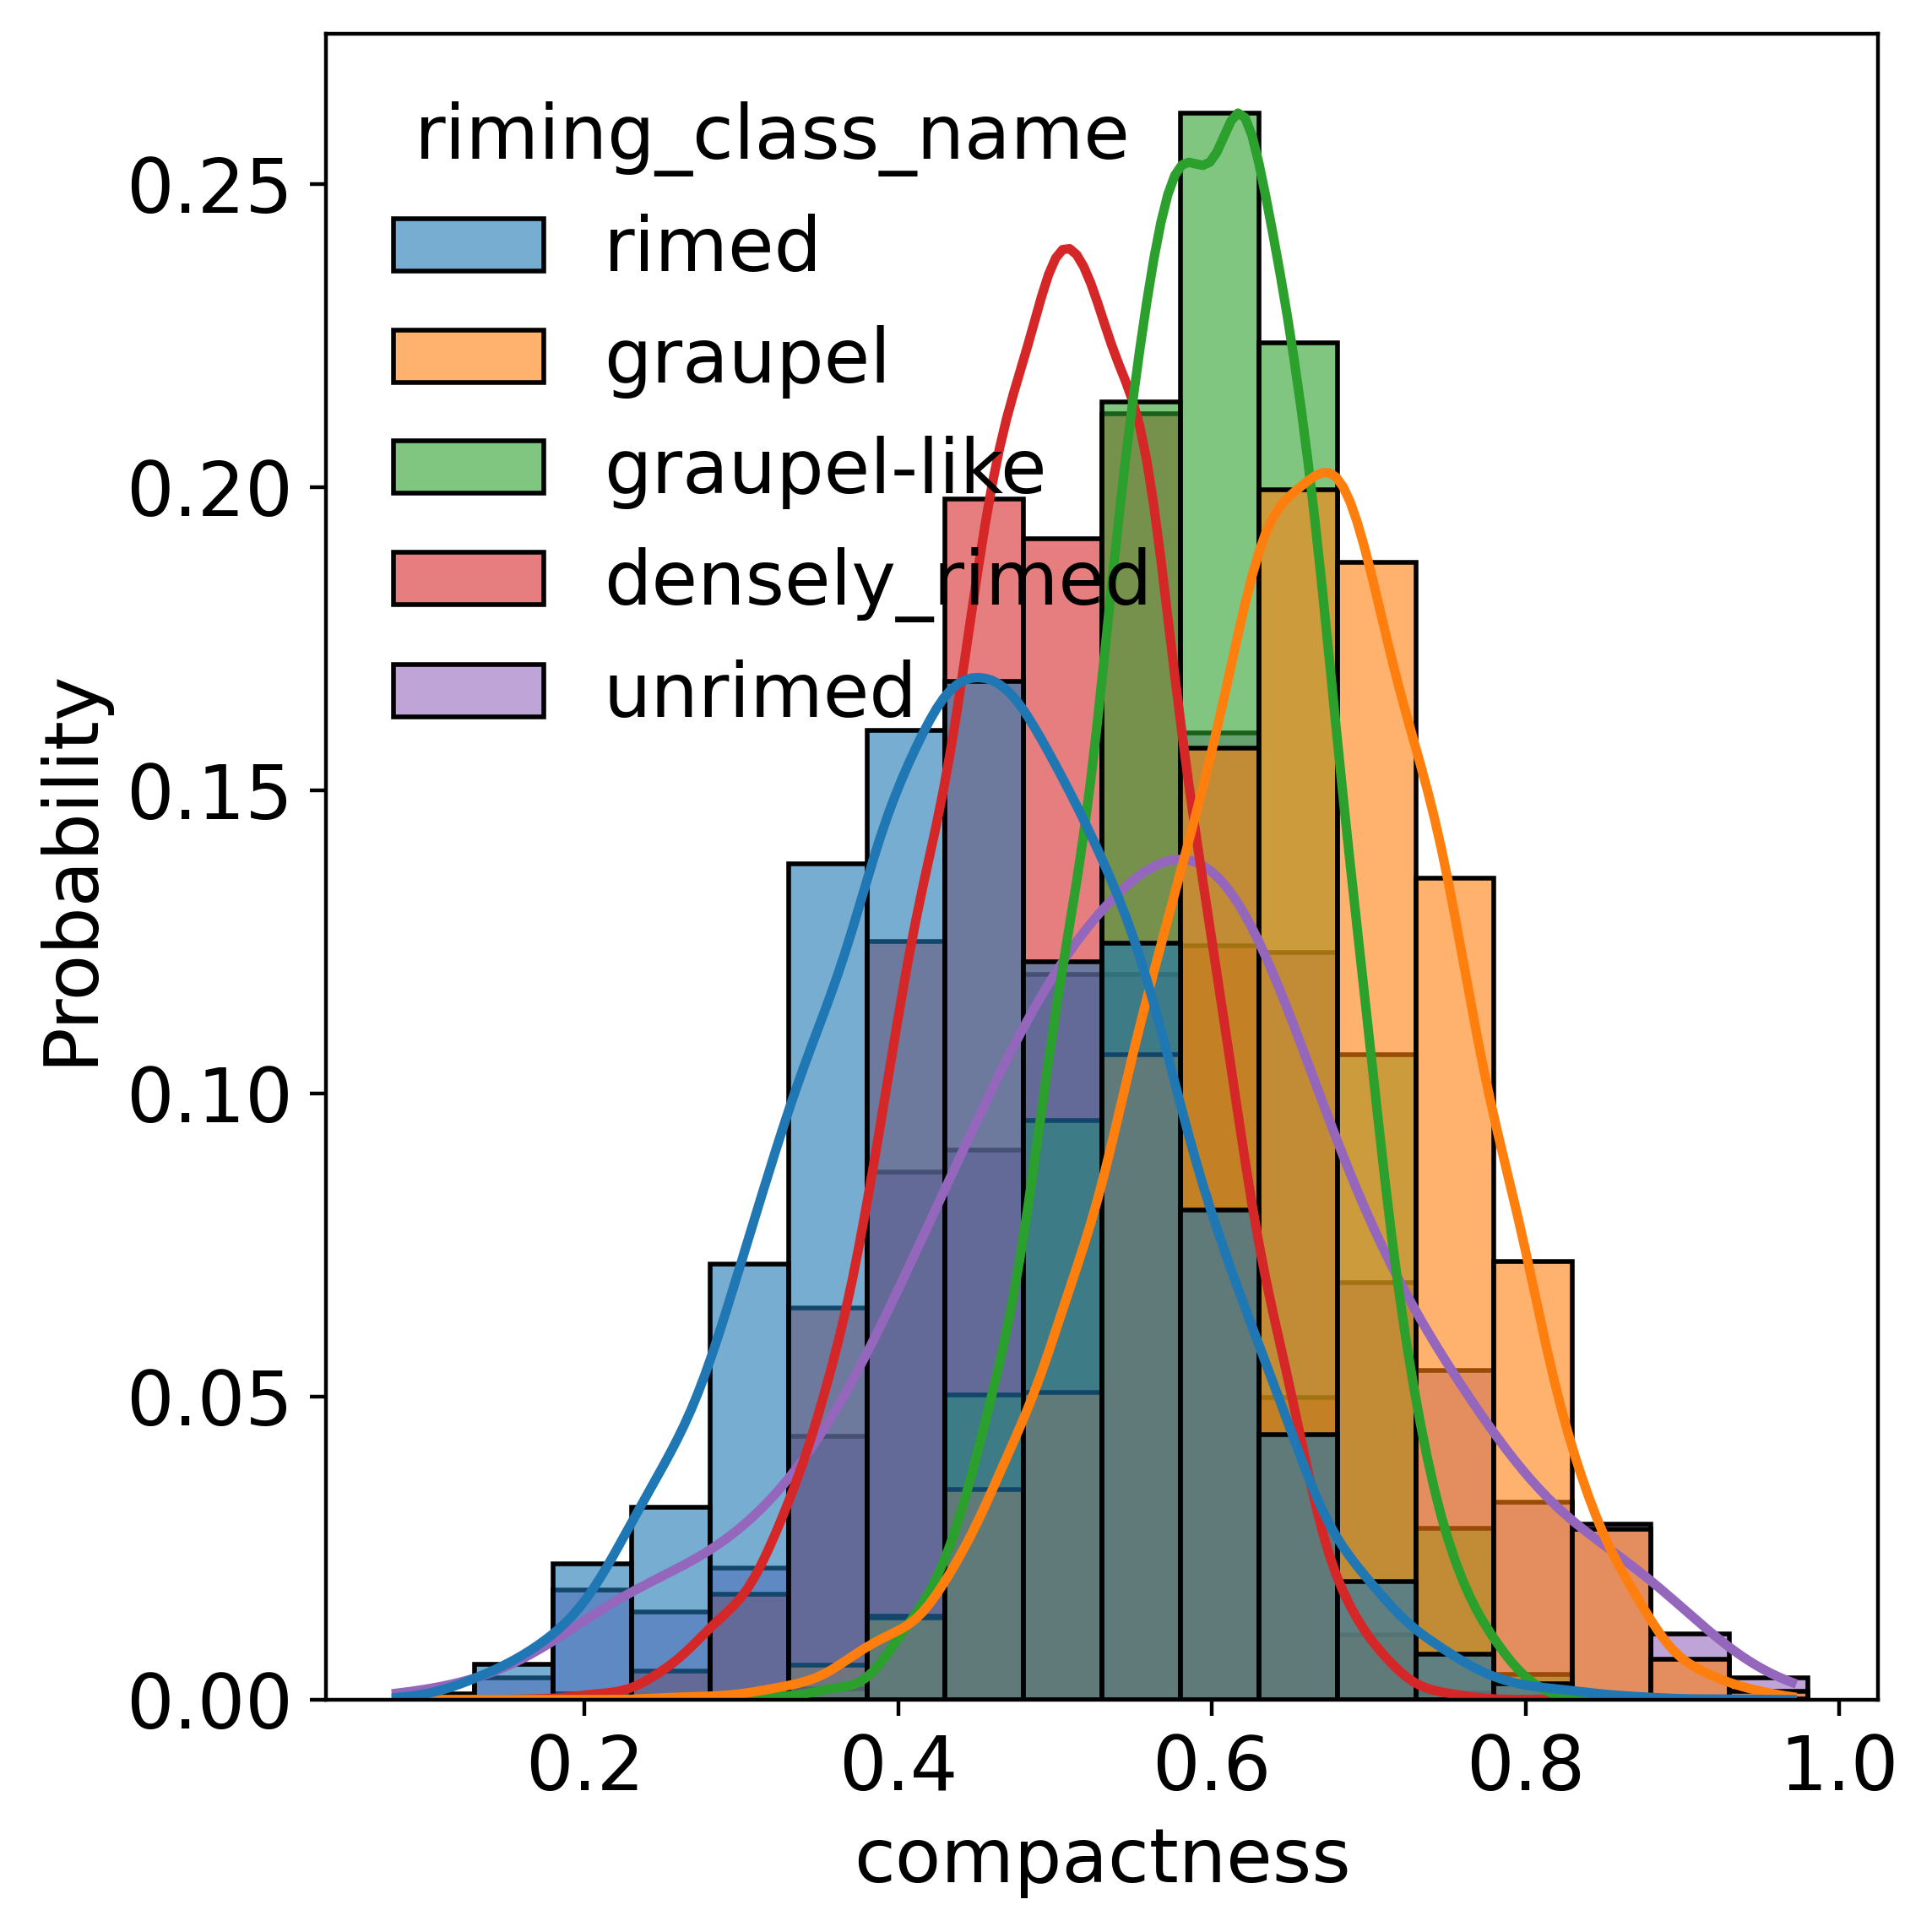

In [12]:
# Plot for example compactness factor of each class (using CAM0 in this example)
mascdb_in = mascdb_in.discard_riming_class('undefined',df_source='cam0')

plt.figure(figsize=(6,6), tight_layout=True)
ax=mascdb_in.cam0.sns.histplot(x='compactness',
                              color='gray',
                              hue='riming_class_name',
                              alpha=0.6,
                              kde=True,
                              stat='probability',
                              common_norm=False,
                              binwidth=0.05,
                              line_kws={"lw":2})

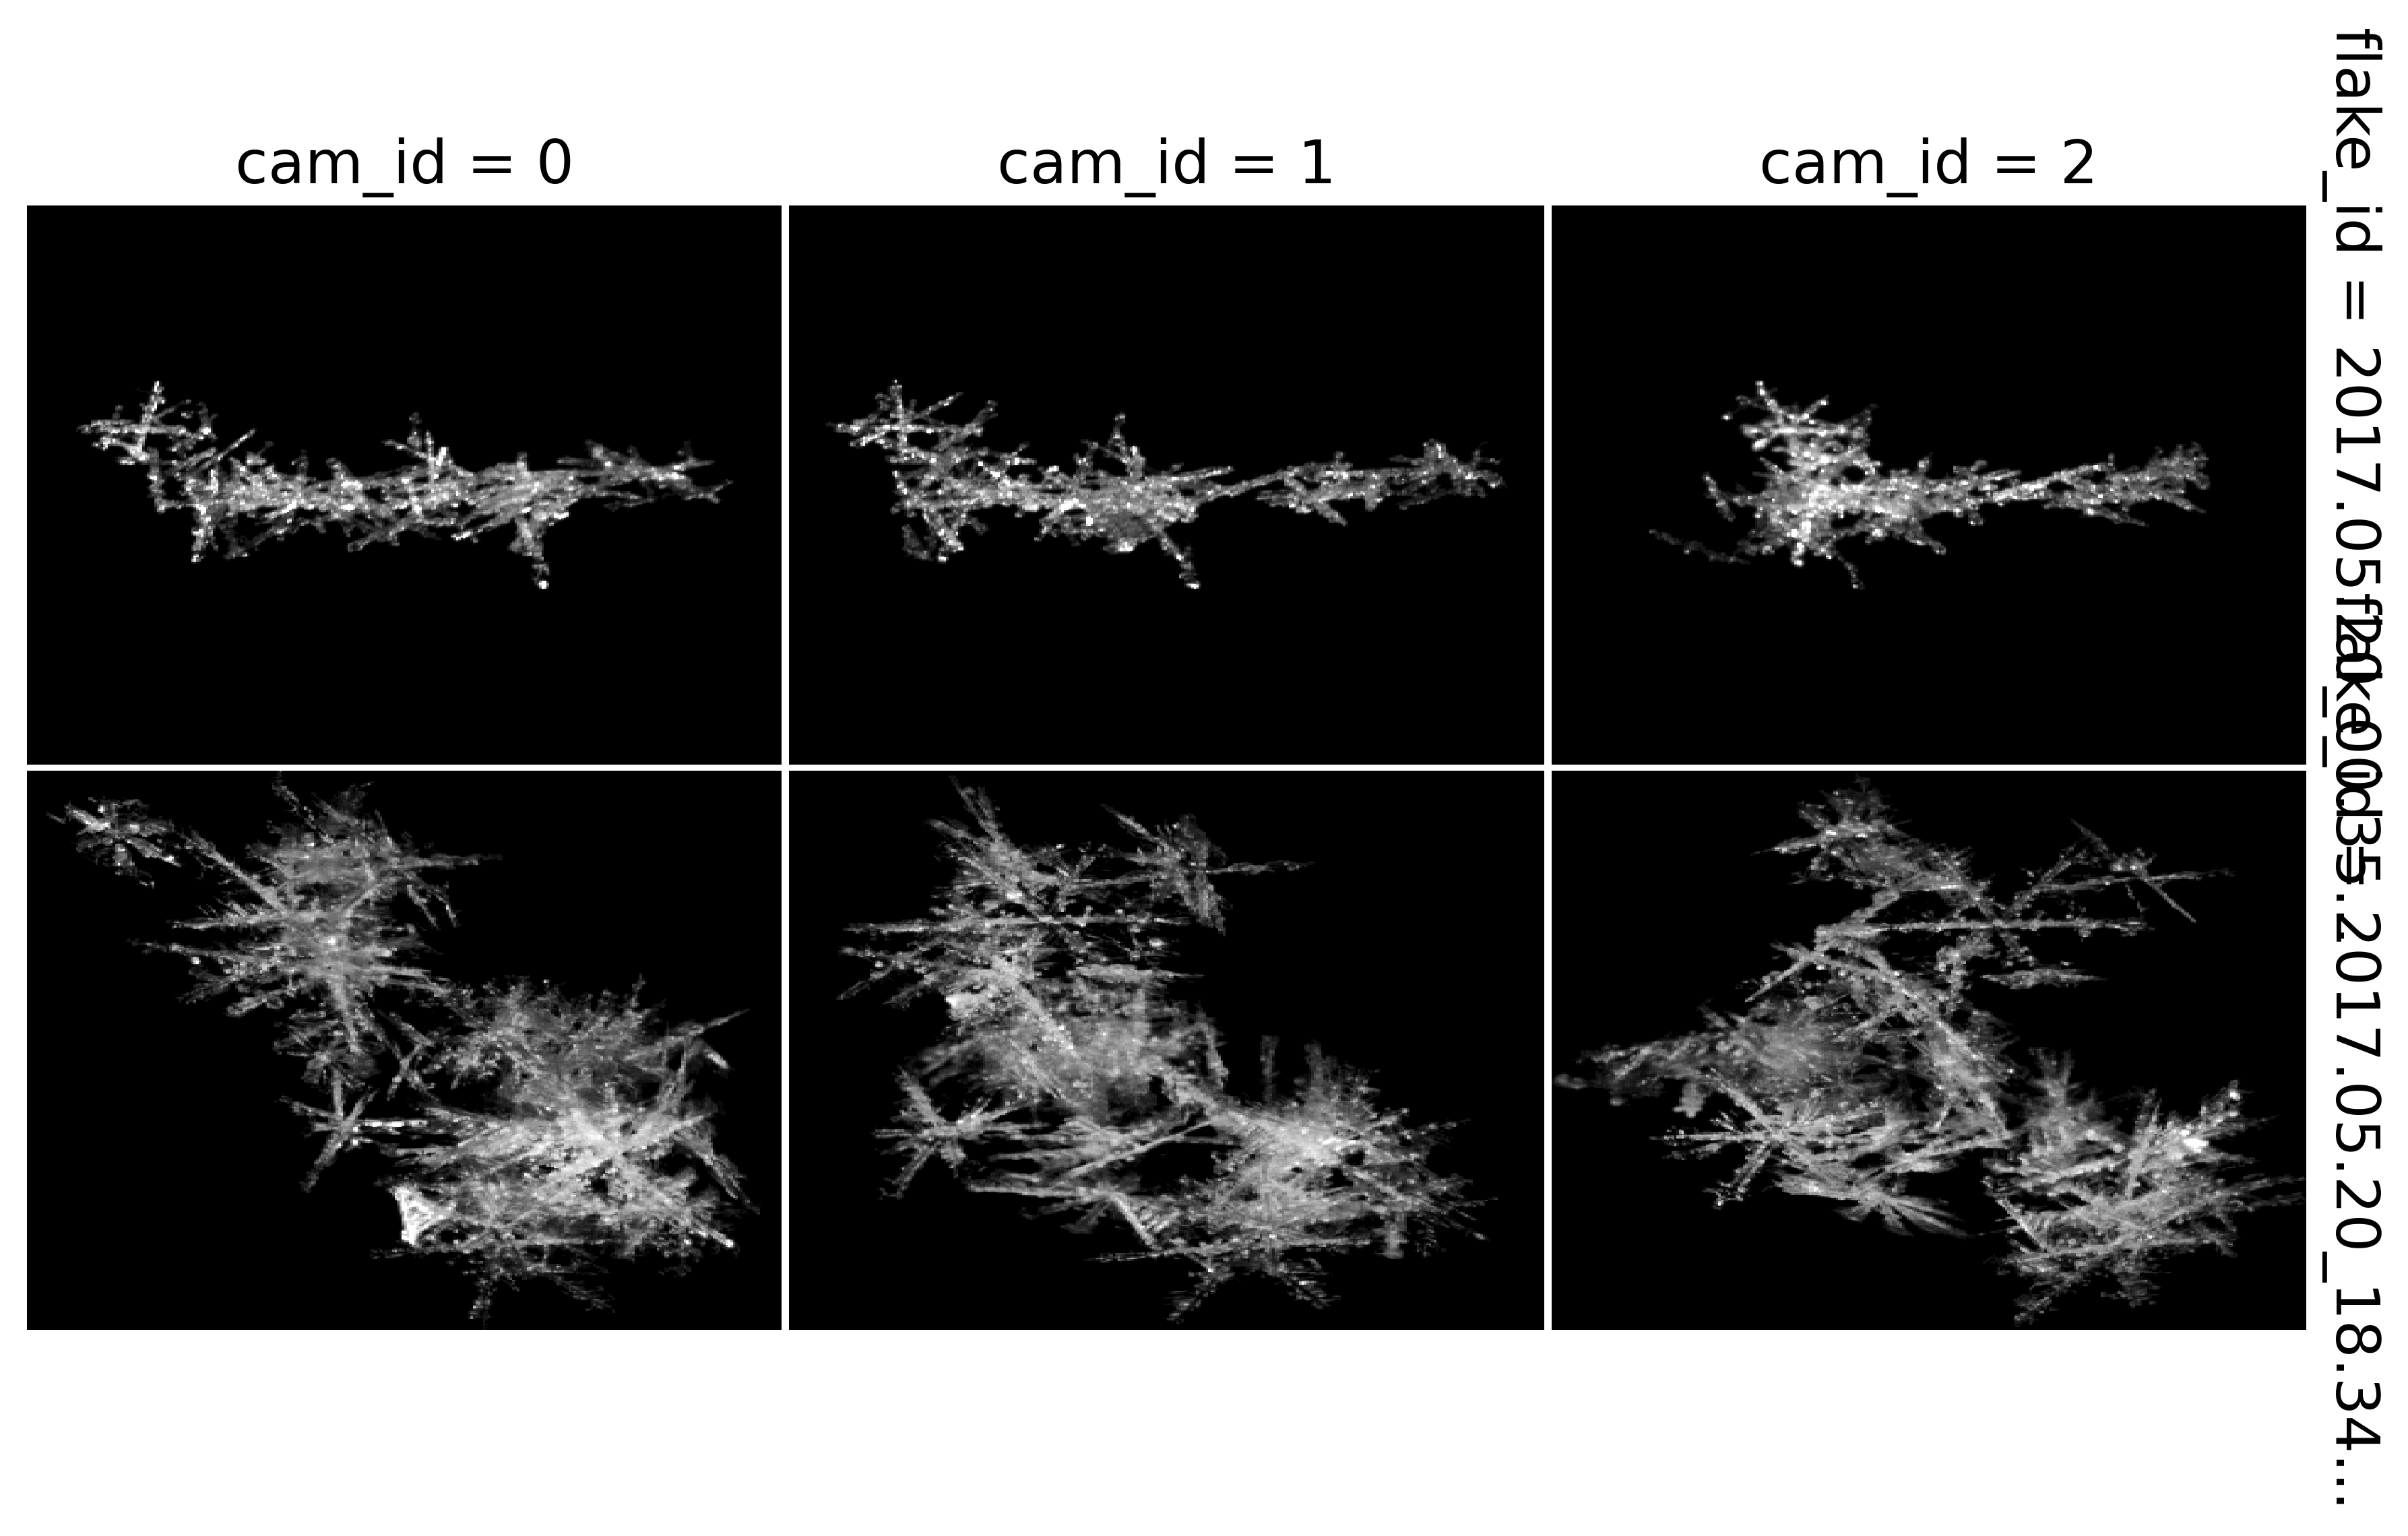

In [17]:
# Plot two  moderately rimed example
mascdb_rimed = mascdb_in.select_riming_class("rimed")

# Sort on quality
mascdb_rimed = mascdb_rimed.arrange('triplet.flake_quality_xhi', decreasing=True) 
mascdb_rimed.plot_triplets(n_triplets = 2, zoom=True)

/home/grazioli/anaconda3/envs/mascdb/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]


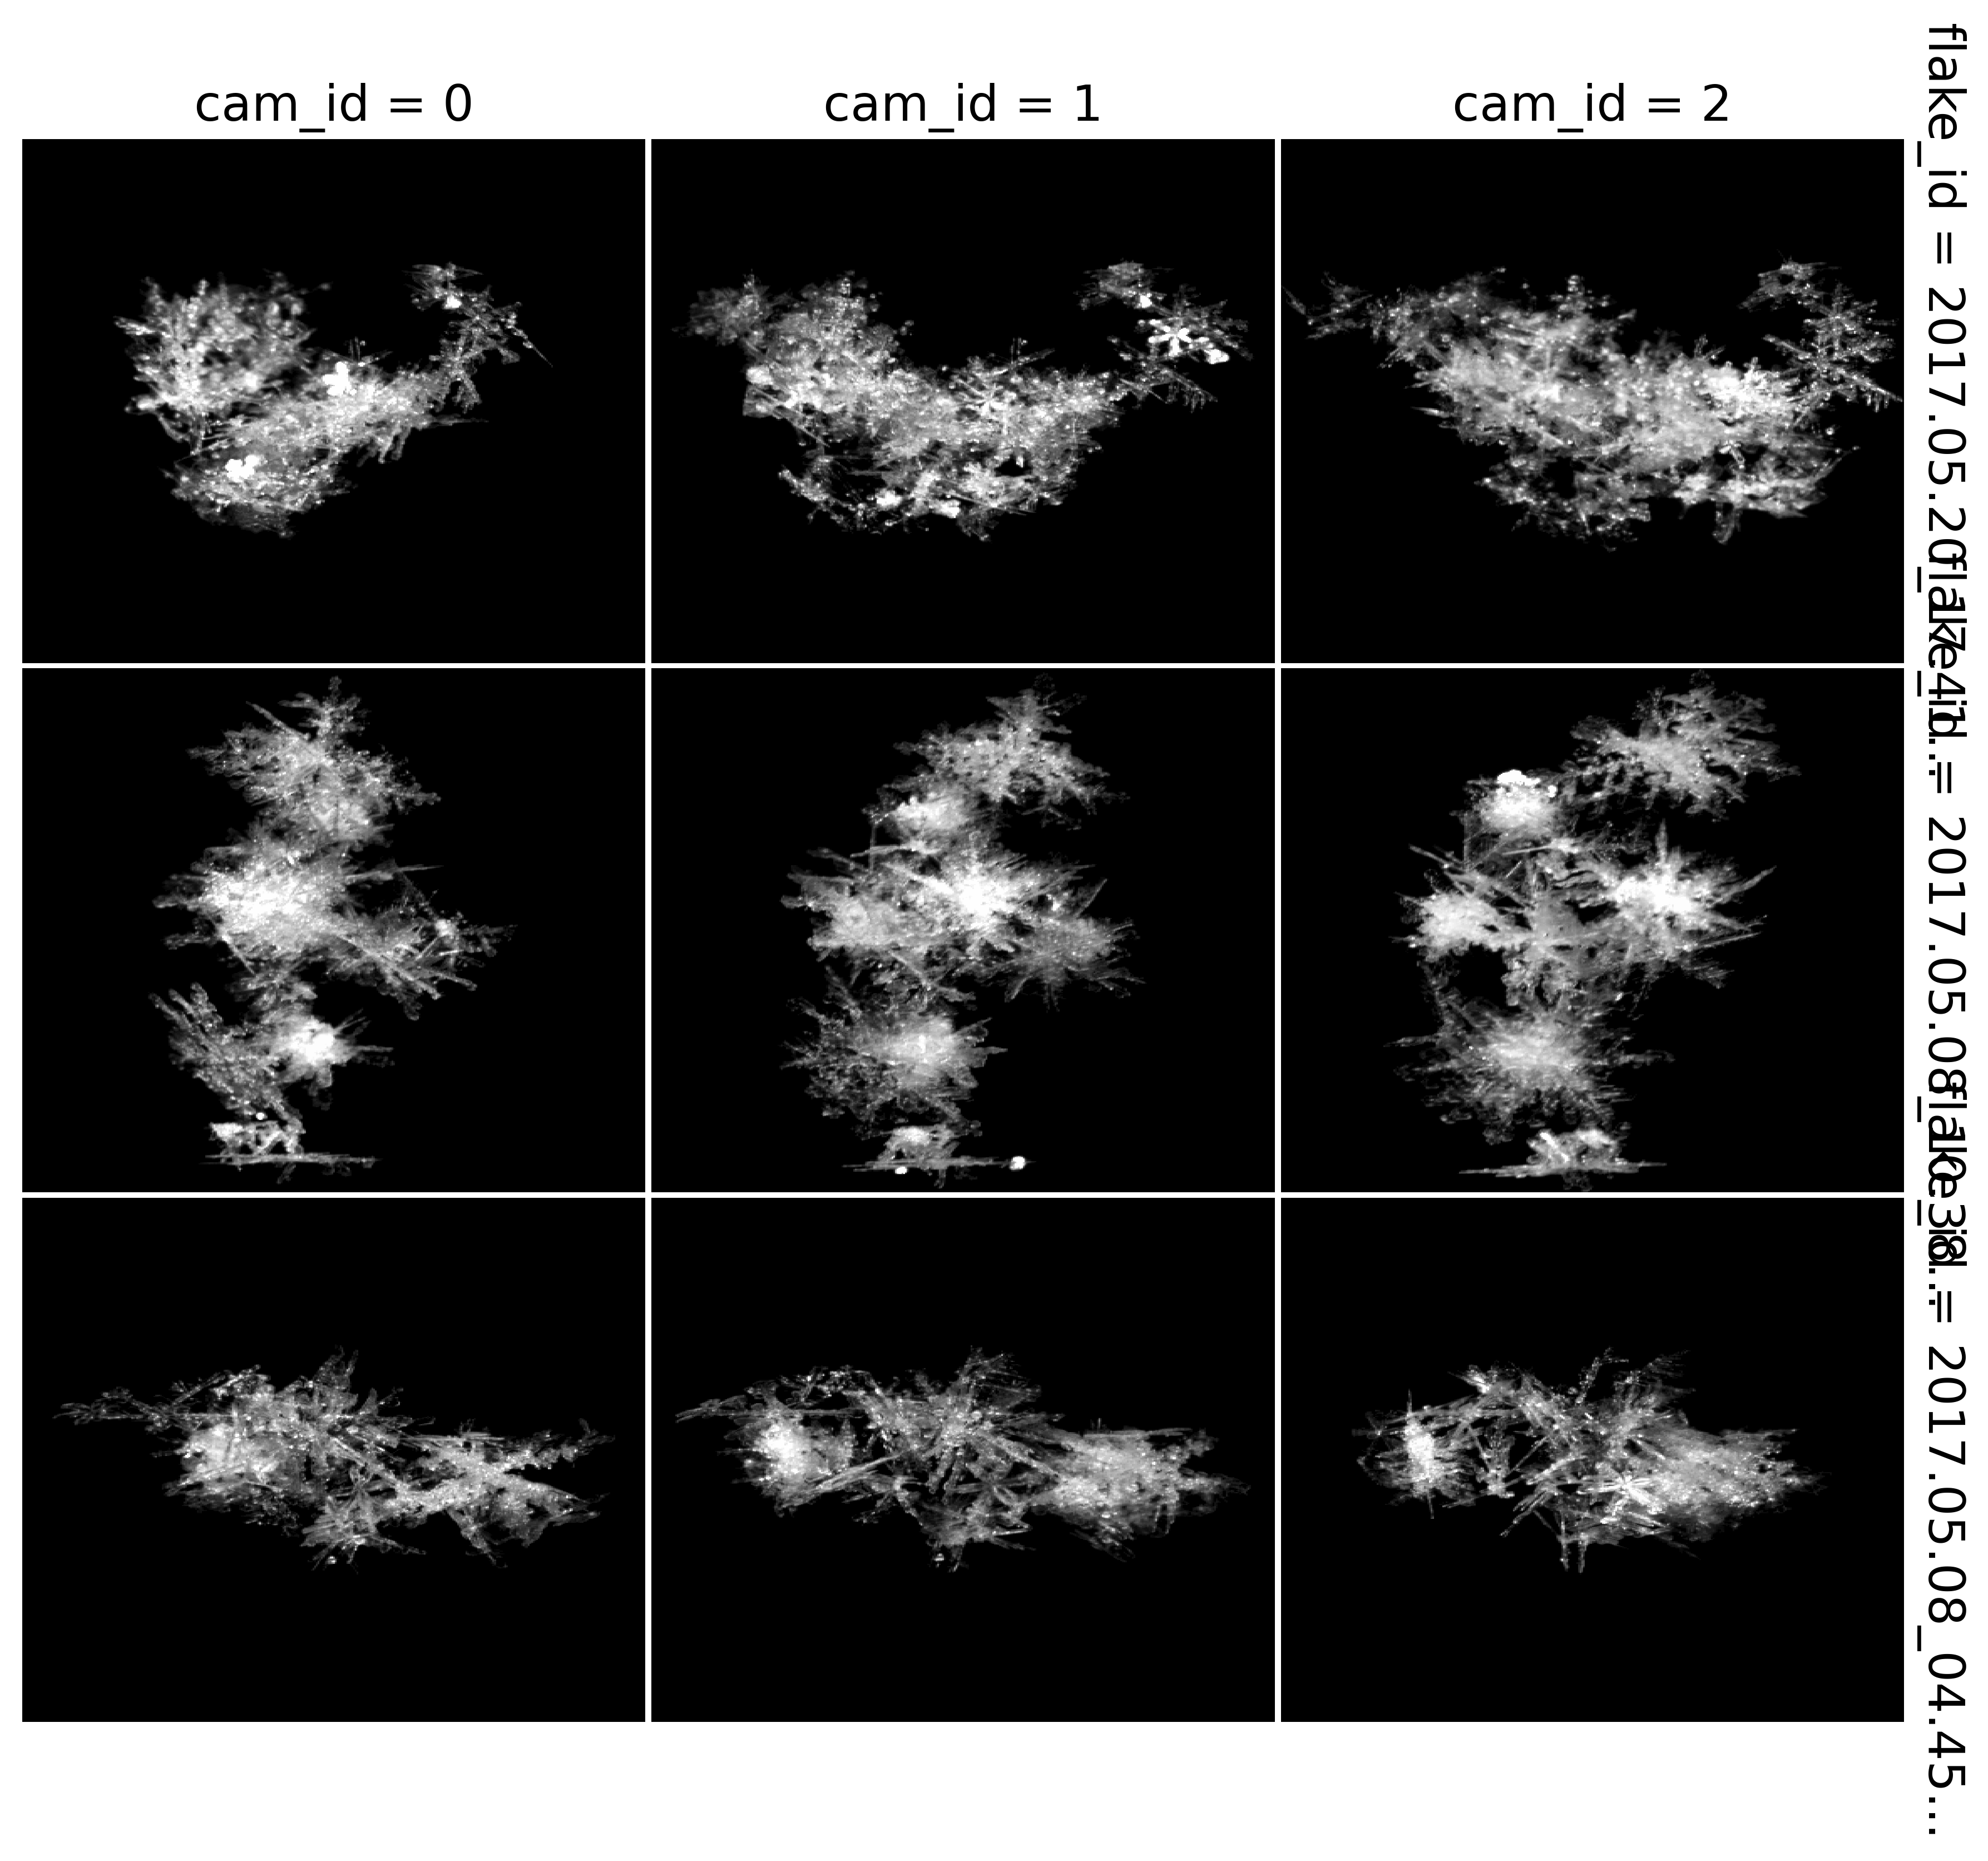

In [21]:
# Plot three  densely rimed example
mascdb_rimed = mascdb_in.select_riming_class("densely_rimed")

# Sort on quality
mascdb_rimed = mascdb_rimed.arrange('triplet.flake_quality_xhi', decreasing=True) 
mascdb_rimed.plot_triplets(n_triplets = 3, zoom=True)